<!---
layout: post
title: Influence Maximization in Python - Greedy vs CELF
tags: 
- Python
- igraph
- Network Analysis
- Influence Maximization
--->

<center> <h1>Influential Node Identification to block Information Cascade using two models</h1> </center>

# Code of Group 17


In [ ]:
!pip install python-igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import time
from igraph import *

## Spread Process - Independent Cascade

We first need to specify a function that simulates the spread from a given seed set across the network. We'll simulate the influence spread using the popular "Independent Cascade" model, although there are many others we could have chosen. The `IC()` function describing the spread process is presented below.

In [ ]:
def IC(g,S,p=0.5,mc=1000):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                
                # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g.neighbors(node,mode="out"))) < p
                new_ones += list(np.extract(success, g.neighbors(node,mode="out")))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            
        spread.append(len(A))
        
    return(np.mean(spread))

We calculate the expected spread of a given seed set by taking the average over a large number (`mc`) of Monte Carlo simulations. The outer loop in the `IC()` function iterates over each of these simulations and stores each calculated spread in the `spread` list. 

## Greedy Algorithm

We begin with the **Greedy** algorithm. This basically finds the node with the biggest spread, adds it to the seed set and then finds the node with the next biggest marginal spread over and above the spread of the original and so on until $k$ seed nodes are found.

The following `greedy()` function implements the algorithm. It produces the optimal set of `k` seed nodes for the graph `g`, and is explained in more detail below.

In [ ]:
def greedy(g,k,p=0.1,mc=1000):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    S, spread, timelapse, start_time = [], [], [], time.time()
    
    # Find k nodes with largest marginal gain
    for _ in range(k):

        # Loop over nodes that are not yet in seed set to find biggest marginal gain
        best_spread = 0
        for j in set(range(g.vcount()))-set(S):

            # Get the spread
            s = IC(g,S + [j],p,mc)

            # Update the winning node and spread so far
            if s > best_spread:
                best_spread, node = s, j

        # Add the selected node to the seed set
        S.append(node)
        
        # Add estimated spread and elapsed time
        spread.append(best_spread)
        timelapse.append(time.time() - start_time)

    return(S,spread,timelapse)

The `greedy()` function performs the same operation for all $k$ iterations of the outer `for` loop. Specifically, it calculates the marginal spread for all remaining candidate nodes and then selects the node with the highest spread.

The function not only returns the optimal seed set `S` but also the average spread of that seed set along with a list showing the cumulative time taken to complete each iteration (which we'll compare with CELF below).

## Cost Effective Lazy Forward (CELF) Algorithm

CELF exploits the sub-modularity property of the spread function, which implies that the marginal spread of a given node in one iteration of the Greedy algorithm cannot be any larger than its marginal spread in the previous iteration. This helps us to choose the nodes for which we evaluate the spread function in a more sophisticated manner, rather than simply evaluating the spread for all nodes.

In [ ]:
def celf(g,k,p=0.1,mc=1000):  
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
      
    # --------------------
    # Find the first node with greedy algorithm
    # --------------------
    
    # Calculate the first iteration sorted list
    start_time = time.time() 
    marg_gain = [IC(g,[node],p,mc) for node in range(g.vcount())]

    # Create the sorted list of nodes and their marginal gain 
    Q = sorted(zip(range(g.vcount()),marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [g.vcount()], [time.time()-start_time]
    
    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------
    
    for _ in range(k-1):    

        check, node_lookup = False, 0
        
        while not check:
            
            # Count the number of times the spread is computed
            node_lookup += 1
            
            # Recalculate spread of top node
            current = Q[0][0]
            
            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(g,S+[current],p,mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)

## Result 1: A Simple Test Run

We'll first test these algorithms to see if they can produce the correct solution for a simple example for which we know the two most influential nodes. Below we create a 10-node/20-edge weighted and directed `igraph` network object. We also make sure that `0` and `1` are not neighbors so that having one in the seed set does not make the other redundant. Plotting the network allows us to gain some visual intuition as to why nodes `0` and `1` are the most influential.

In [ ]:
#!pip install pycairo

In [ ]:
#!pip install python-igraph==0.8.3
!apt install libcairo2-dev pkg-config python3-dev
!pip install python-igraph leidenalg cairocffi


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-4ubuntu1).
pkg-config is already the newest version (0.29.1-0ubuntu4).
python3-dev is already the newest version (3.8.2-0ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import cairo
# Create simple network with 0 and 1 as the influential nodes
source = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,3,4,5]
target = [2,3,4,5,6,7,8,9,2,3,4,5,6,7,8,9,6,7,8,9]

g = Graph(directed=True)
g.add_vertices(range(10))
g.add_edges(zip(source,target))

# Plot graph

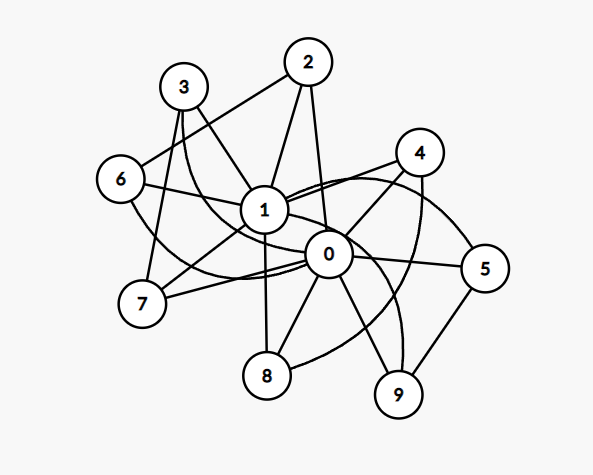

With this graph in hand we can now run each of the algorithms, which both manage to correctly identify nodes 0 and 1 as the influencers. This gives us some confidence that our code is working correctly.

In [ ]:
# Run algorithms
celf_output   = celf(g,2,p = 0.2,mc = 1000)
greedy_output = greedy(g,2,p = 0.2,mc = 1000)

# Print results
print("celf output:   " + str(celf_output[0]))
print("greedy output: " + str(greedy_output[0]))

celf output:   [0, 1]
greedy output: [0, 1]


## Result 2: Larger Network

Now that we know that both alorithms at least work correctly for a simple network for which we know the answer, we move to a more generic graph to compare the performance and efficiency of each method. Any `igraph` network object will work, but for the purposes of this post we will use a random Erdos-Renyi graph with 100 nodes and 300 edges. The exact type of graph doesn't matter as the main points hold for any graph. Rather than explicitly defining the nodes and edges like we did above, here we make use of the `.Erdos_Renyi()` method to automatically create the graph. Plotting the network shows that we're now dealing with a larger more complicated network where the identity of the most influential nodes is no longer obvious.


In [ ]:
# Generate Graph
G = Graph.Erdos_Renyi(n=100,m=300,directed=True)

# Plot Graph

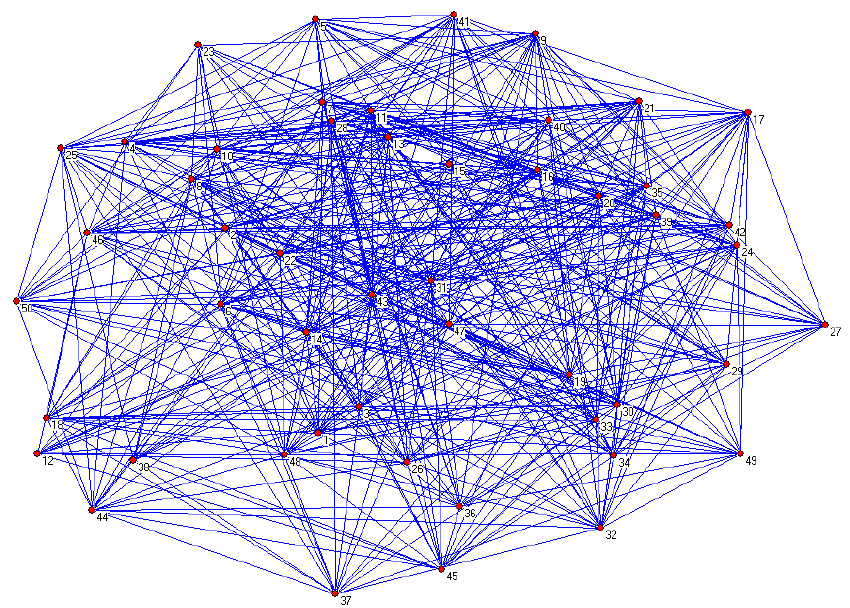

In [ ]:
# Run algorithms
celf_output   = celf(G,10,p = 0.1,mc = 1000)
greedy_output = greedy(G,10,p = 0.1,mc = 1000)

# Print resulting seed sets
print("celf output:   " + str(celf_output[0]))
print("greedy output: " + str(greedy_output[0]))

celf output:   [42, 0, 78, 41, 75, 20, 67, 72, 68, 94]
greedy output: [42, 0, 78, 41, 75, 20, 67, 72, 68, 94]


We now compare the speed of each algorithm. The plot below shows that the computation time of Greedy is larger than CELF for all seed set sizes greater than 1 and the difference in computational times grows exponenitally with the size of the seed set. This is because Greedy must compute the spread of $N-i-1$ nodes in iteration $i$ whereas CELF generally performs far fewer spread computations after the first iteration.

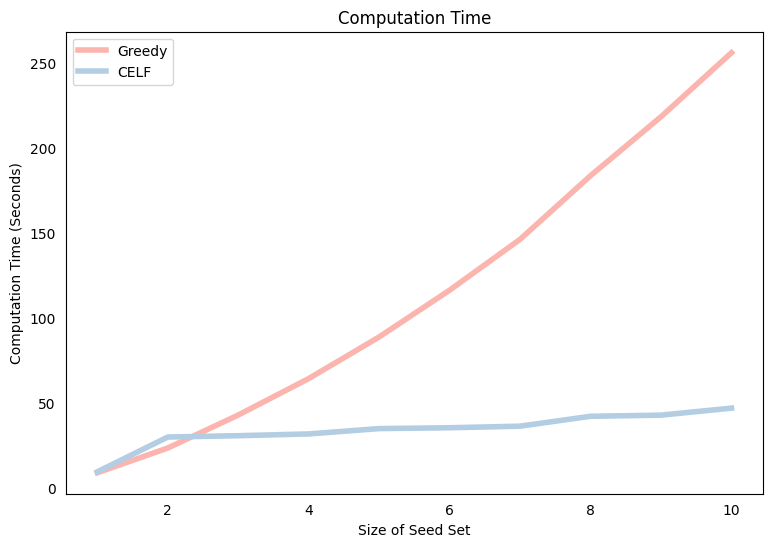

In [ ]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(greedy_output[2])+1),greedy_output[2],label="Greedy",color="#FBB4AE")
plt.plot(range(1,len(celf_output[2])+1),celf_output[2],label="CELF",color="#B3CDE3")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2);

Finally, we plot the resulting expected spread for each seed set size. Of course, both methods yield the same expected spread, which is simply a function of the identical seed sets, but note that the function is concave, which is consistent with the submodularity of the spread function.

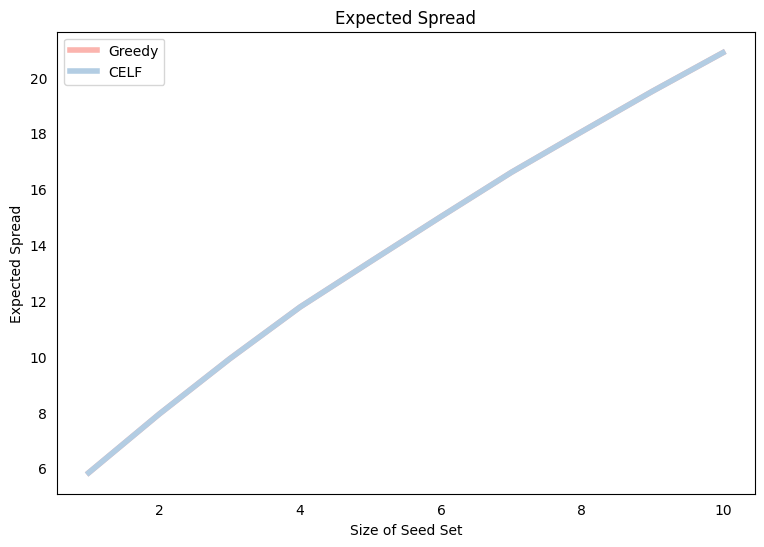

In [ ]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(greedy_output[1])+1),greedy_output[1],label="Greedy",color="#FBB4AE")
plt.plot(range(1,len(celf_output[1])+1),celf_output[1],label="CELF",color="#B3CDE3")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2);

## Conclusion

We implemented both the Greedy and CELF algorithms as simple Python functions and showed the following:

- Both correctly identify the influential nodes in simple examples
- Both result in the same seed set
- The CELF algorithm runs a lot faster for any seed set $k>1$.
- The speed arises from the fact that after the first round, CELF performs far fewer spread computations than Greedy.